### Introdução

O objetivo deste problema é criar um modelo de predição para determinar o valor imobiliário de casas.

##### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
import datetime
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from sklearn.model_selection import KFold

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

### Importação dos dados

In [2]:
raw_data=pd.read_csv('train.csv')
pd.set_option('display.max_columns', 50)

In [3]:
df=raw_data.copy()

### SalePrice

Inicialmente observamos que a distribuição da variável SalePrice apresenta assimetria.

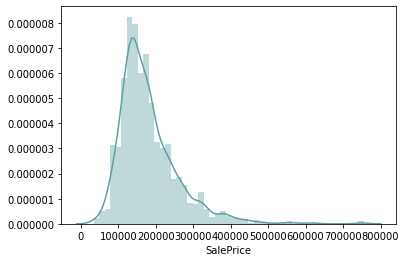

In [4]:
sns.distplot(df['SalePrice'],color='cadetblue')

Skewness: 1.882876
Kurtosis: 6.536282


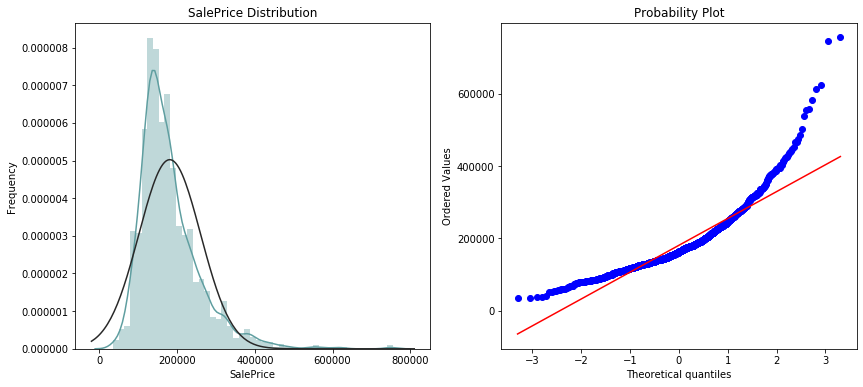

In [5]:
df1=df.copy()
print("Skewness: %f" % df1['SalePrice'].skew())
print("Kurtosis: %f" % df1['SalePrice'].kurt())

figure = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.distplot(df['SalePrice'] , fit=norm,color='cadetblue');
(mu, sigma) = norm.fit(df1['SalePrice'])
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

plt.subplot(1,2,2)
stats.probplot(df1['SalePrice'], plot=plt)
plt.show()

Vamos analisar também a relação da variável SalePrice com algumas outras variáveis numéricas.

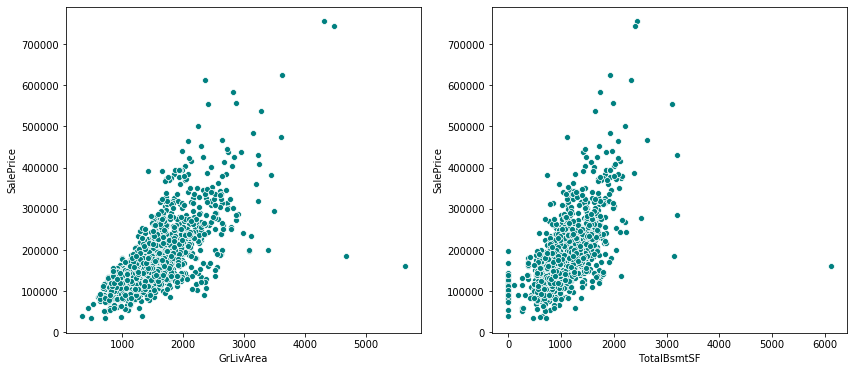

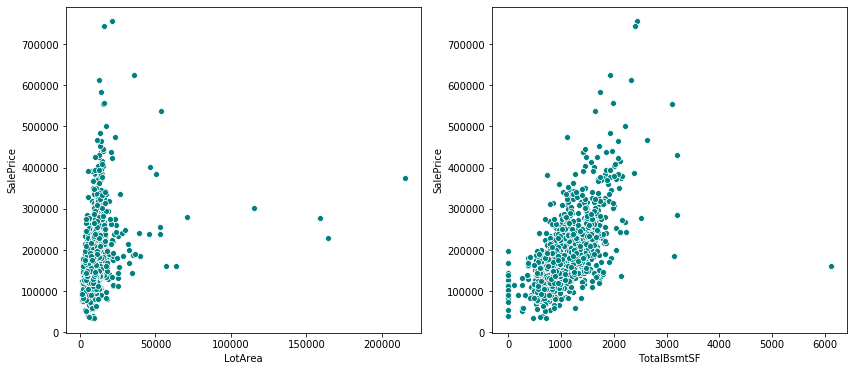

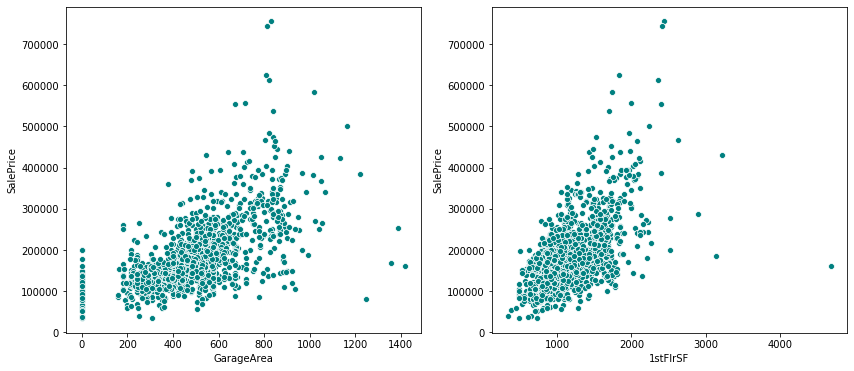

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot( x = df['GrLivArea'], y = df['SalePrice'],ax = ax[0],edgecolor="w",color='teal')
   
sns.scatterplot(x = df['TotalBsmtSF'], y = df['SalePrice'],ax = ax[1],edgecolor="w",color='teal')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot( x = df['LotArea'], y = df['SalePrice'],ax = ax[0],edgecolor="w",color='teal')
   
sns.scatterplot(x = df['TotalBsmtSF'], y = df['SalePrice'],ax = ax[1],edgecolor="w",color='teal')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot( x = df['GarageArea'], y = df['SalePrice'],ax = ax[0],edgecolor="w",color='teal')
   
sns.scatterplot(x = df['1stFlrSF'], y = df['SalePrice'],ax = ax[1],edgecolor="w",color='teal')


Observamos a presença de outliers em SalePrice, GrLicArea, TotalBsmtSF, LotArea, GarageArea e 1stF1rSR. A seguir removeremos os outliers e analisaremos novamente a distribuição de SalePrice.

In [7]:
df=df[(df['SalePrice']<300000)]
df=df[(df['GrLivArea']<3500)]
df=df[(df['TotalBsmtSF']<2500)]
df=df[(df['LotArea']<25000)]
df=df[(df['GarageArea']<1100)]
df=df[(df['1stFlrSF']<3000)]

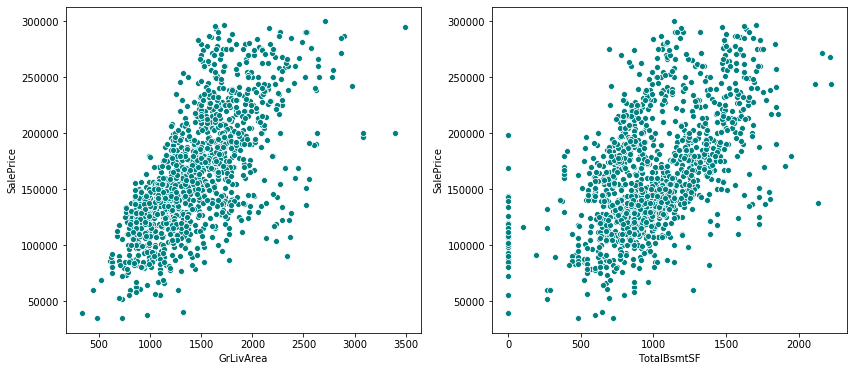

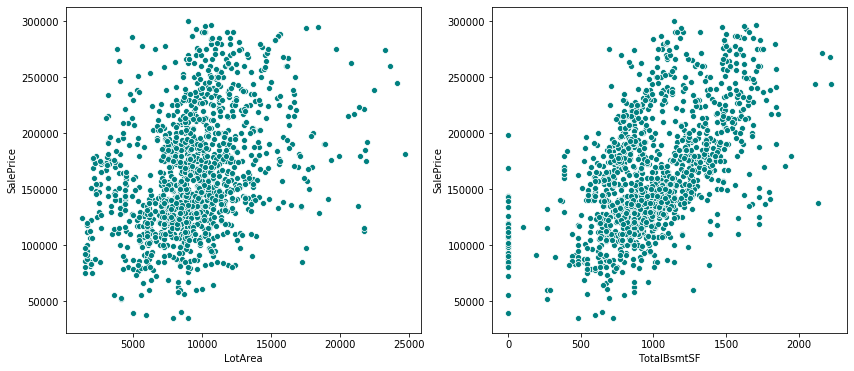

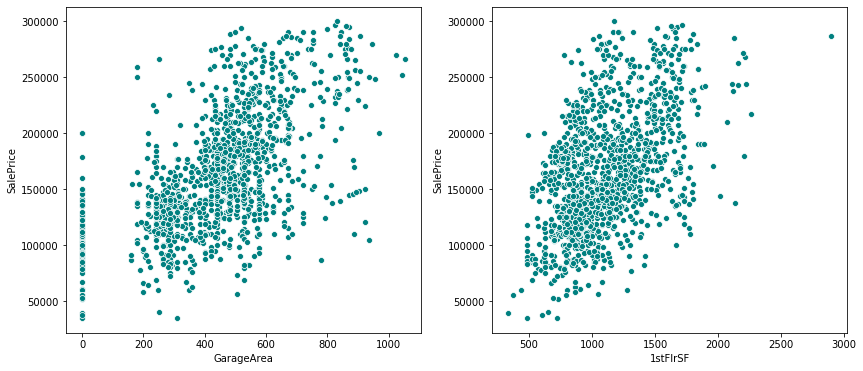

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot( x = df['GrLivArea'], y = df['SalePrice'],ax = ax[0],edgecolor="w",color='teal')
   
sns.scatterplot(x = df['TotalBsmtSF'], y = df['SalePrice'],ax = ax[1],edgecolor="w",color='teal')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot( x = df['LotArea'], y = df['SalePrice'],ax = ax[0],edgecolor="w",color='teal')
   
sns.scatterplot(x = df['TotalBsmtSF'], y = df['SalePrice'],ax = ax[1],edgecolor="w",color='teal')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

sns.scatterplot( x = df['GarageArea'], y = df['SalePrice'],ax = ax[0],edgecolor="w",color='teal')
   
sns.scatterplot(x = df['1stFlrSF'], y = df['SalePrice'],ax = ax[1],edgecolor="w",color='teal')


Skewness: 0.437213
Kurtosis: -0.267531


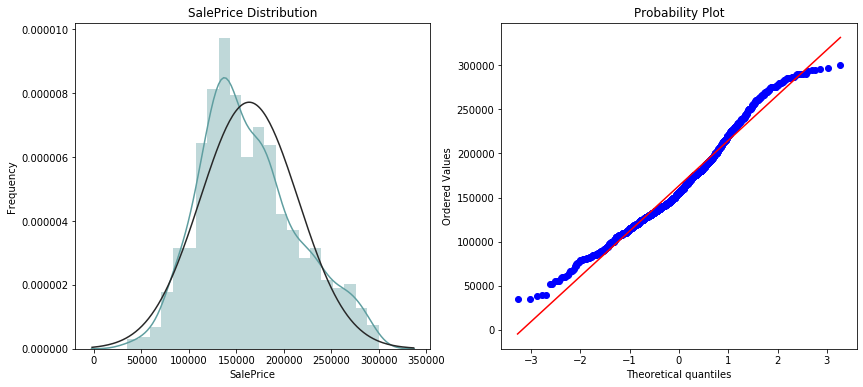

In [9]:
df1=df.copy()
print("Skewness: %f" % df1['SalePrice'].skew())
print("Kurtosis: %f" % df1['SalePrice'].kurt())

figure = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.distplot(df['SalePrice'] , fit=norm,color='cadetblue');
(mu, sigma) = norm.fit(df1['SalePrice'])
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

plt.subplot(1,2,2)
stats.probplot(df1['SalePrice'], plot=plt)
plt.show()

Agora a distribuição está perto de uma distribuição normal.

### Tratamento dos valores nulos

Inicialmente vamos identificar quais colunas apresentam valores nulos.

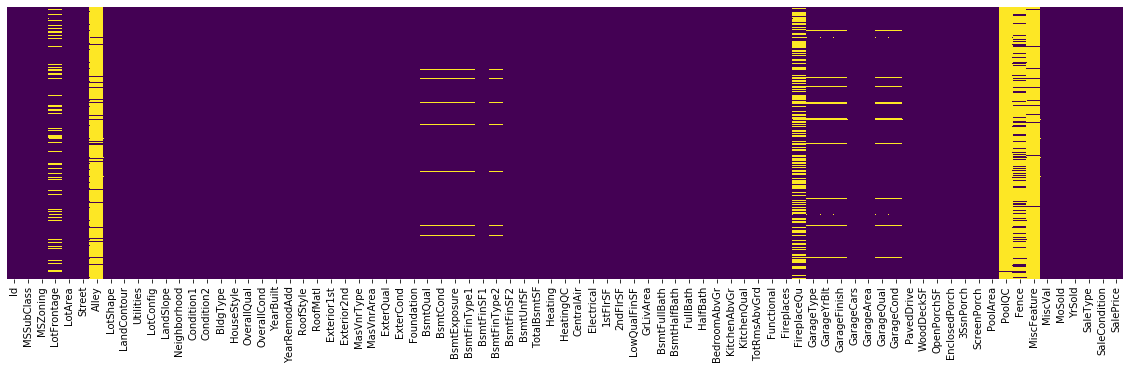

In [10]:
# Checar a quantidade de valores nulos em cada coluna
plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Visualização das variáveis nulas

Text(0.5, 1.0, '% valores nulos')

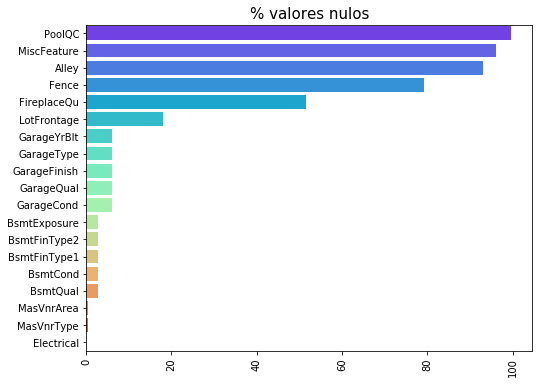

In [11]:
list_nan = (df.isnull().sum() / len(df)) * 100
list_nan = list_nan.drop(list_nan[list_nan == 0].index).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=list_nan, y=list_nan.index,palette='rainbow')
plt.xticks(rotation='90')
plt.title('% valores nulos', fontsize=15)

O gráfico acima mostra a porcentagem de valores nulos por coluna. A seguir faremos o tratamento adequado para preenchemento destes valores.

In [12]:
# Separação das variáveis numéricas e categéoricas

num_var=df.drop('SalePrice',1).select_dtypes([np.int64,np.float64]).columns
cat_var=df.select_dtypes([np.object]).columns

Para facilitar a inspeção e manipulação dos dados, agruparemos as colunas do nosso dataset por categorias.

In [13]:
# Vamos separar as colunas por categorias

basement=[]
for n  in df.columns:
    if n.find('Bsmt') != -1 or n.find('Basement') != -1:
        basement.append(n)
garage=[]
for n  in df.columns:
    if n.find('Garage') != -1:
        garage.append(n)

porch=[]
for n  in df.columns:
    if n.find('Porch') != -1:
        porch.append(n)
        
roof=[]
for n  in df.columns:
    if n.find('Roof') != -1:
        roof.append(n)
        
pool=[]
for n  in df.columns:
    if n.find('Pool') != -1:
        pool.append(n)

alley=[]        
for n  in df.columns:
    if n.find('Alley') != -1:
        alley.append(n)
        
exterior=[]
for n  in df.columns:
    if n.find('Exter') != -1 or n.find('Exterior') != -1:
        exterior.append(n)
        
bath=[]
for n  in df.columns:
    if n.find('Bath') != -1:
        bath.append(n)

kitchen=[]
for n  in df.columns:
    if n.find('Kitchen') != -1:
        kitchen.append(n)
        
mas=[]
for n  in df.columns:
    if n.find('Mas') != -1:
        mas.append(n) 

fireplace=[]
for n  in df.columns:
    if n.find('Fireplace') != -1:
        fireplace.append(n)        
        
sf=[]
for n  in df.columns:
    if n.find('SF') != -1:
        sf.append(n)       
        
other=[] 
for n  in df.columns: 
    if n.find('MSZoning') != -1 or n.find('Sale') != -1  or n.find('Utilities') != -1 or n.find('Fence') != -1 or n.find('Lot') != -1 or n.find('Misc') != -1:
        other.append(n) 

As variáveis a seguir serão tratadas separadamente. Na descrição do dataset, observamos os possíveis valores de cada coluna. Como exemplo, a coluna KitchenQual, pode conter:

- KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       
Quando verificamos os valores únicos contidos na coluna KitchenQual do nosso dataset, observamos que o único valor ausente é 'TA'. Portando, substituiremos os valores nulos por TA.
As variáveis Exterior1st, Exterior2nd e SaleType terão os valores substituídos pela moda. 

In [14]:
# De acordo com o data_description, faremos as seguintes substituições

df['Electrical']=df['Electrical'].fillna('SBrkr')
df['KitchenQual']=df['KitchenQual'].fillna('TA')
df['Functional']=df['Functional'].fillna('Typ')
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

As outras colunas, terão os valores substituídos da seguinte forma: NA para variáveis categóricas e 0 para as numéricas.

In [15]:
for n in cat_var:
    if n in other or n in basement or n in garage or n in pool or n in alley or n in fireplace or n in sf or n in mas or n in kitchen or n in bath or n in exterior or n in porch:
        if df[n].isnull().sum()!=0:
            df[n]=df[n].fillna('NA')

for n in num_var:
    if n in other or n in basement or n in garage or n in pool or n in alley or n in fireplace or n in sf or n in mas or n in kitchen or n in bath or n in exterior or n in porch:
         if df[n].isnull().sum()!=0:
            df[n] = df[n].replace(np.nan, 0)

In [16]:
# Vamos checar se ainda existem valores nulos
sum(df.isnull().sum())

0

### Variáveis numéricas

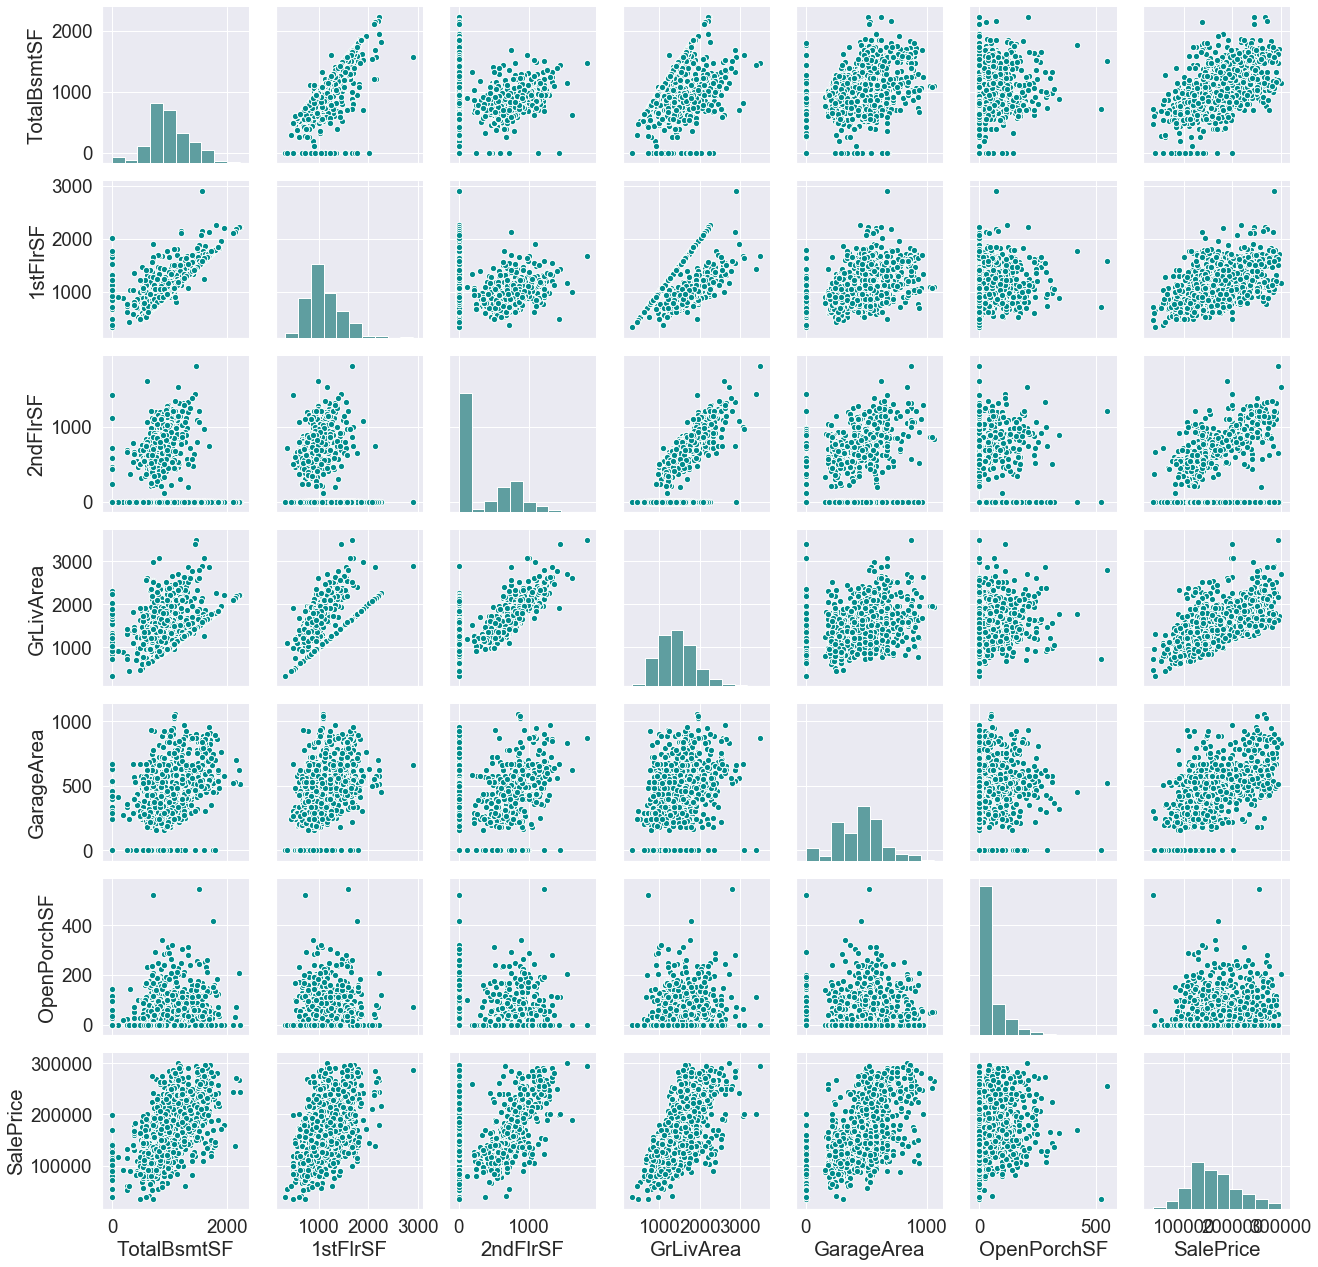

In [17]:
# Antes de prosseguir nas análises, é interessante ter um overview de como algumas das variáveis se relacionam 
#entre si. Para isso, utilizaremos o pairGrids e o correlation heatmap.

sns.set(font_scale=1.7)
g=sns.PairGrid(df, vars=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                        'GrLivArea', 'GarageArea','OpenPorchSF', 'SalePrice'])
g = g.map_offdiag(plt.scatter,linewidths=1, edgecolor="w", s=40,color='darkcyan')
g = g.map_diag(plt.hist, edgecolor="w",color='cadetblue')


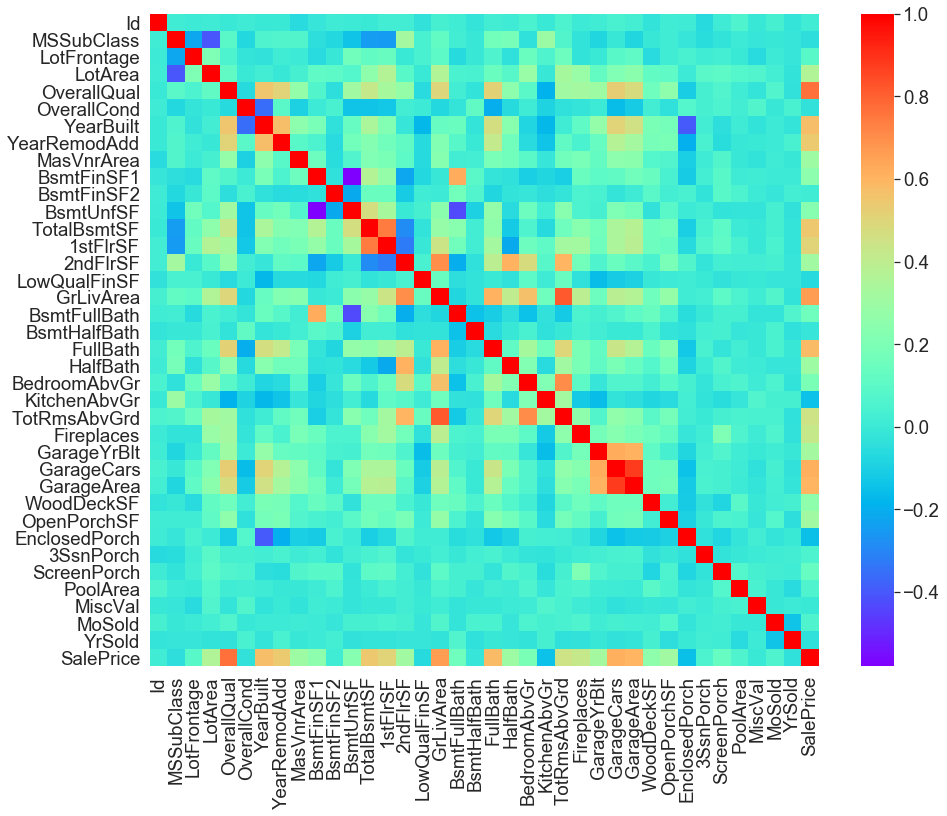

In [18]:
# Analisar a correlação entre as variáveis

plt.figure(figsize=(15,12))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,cmap='rainbow')

Algumas variáveis apresentam alta correlação e talvez possam ser eliminiadas antes da elaboração do modelo. Como por exemplo, GarageArea e GarageCars.

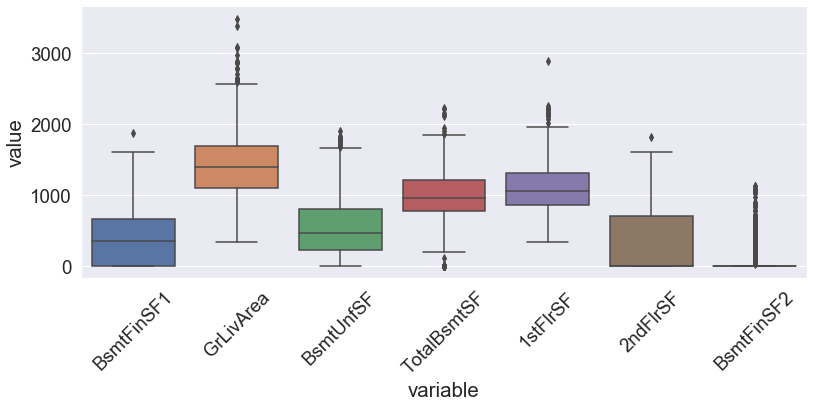

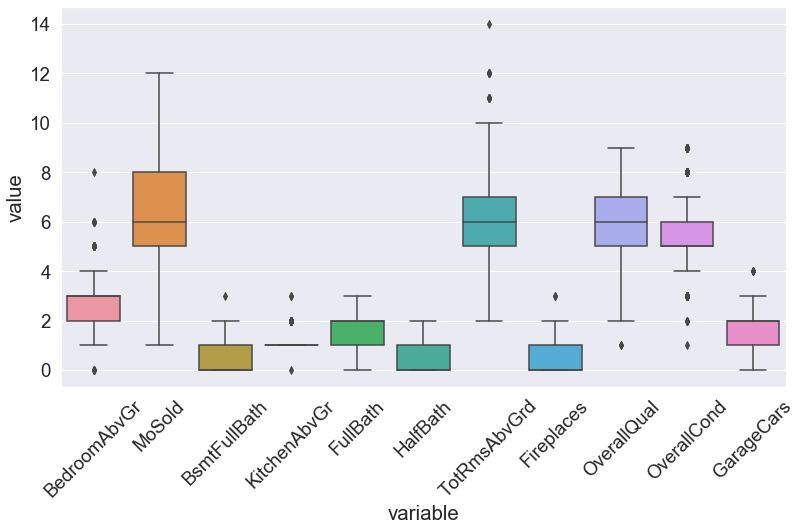

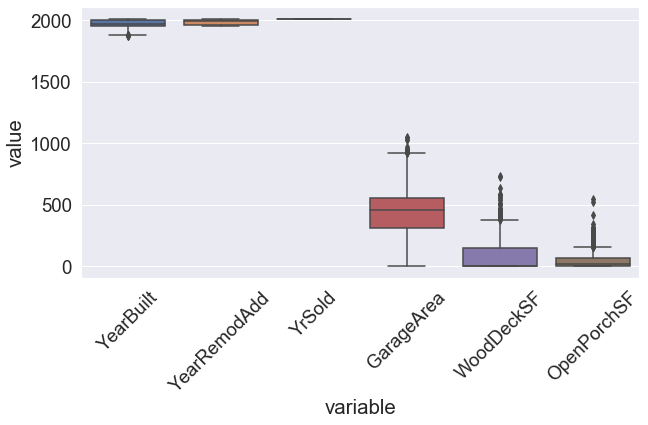

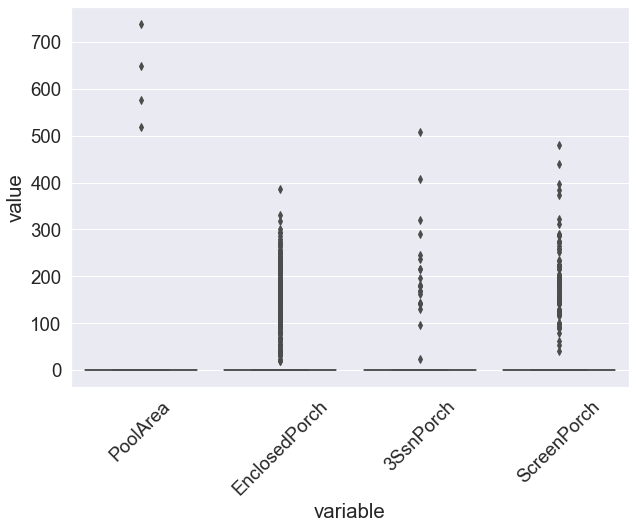

In [19]:
plt.figure(figsize=(13,5))
tab = pd.DataFrame(data = df, columns = ['BsmtFinSF1','GrLivArea' , 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF','2ndFlrSF','BsmtFinSF2' ])
g=sns.boxplot(x="variable", y="value", data=pd.melt(tab))
g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.figure(figsize=(13,7))
tab3 = pd.DataFrame(data = df, columns = ['BedroomAbvGr','MoSold','BsmtFullBath', 'KitchenAbvGr', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'Fireplaces','OverallQual', 'OverallCond','GarageCars'])
r=sns.boxplot(x="variable", y="value", data=pd.melt(tab3))
r.set_xticklabels(r.get_xticklabels(), rotation=45)


plt.figure(figsize=(10,5))
tab2 = pd.DataFrame(data = df, columns = ['YearBuilt', 'YearRemodAdd','YrSold','GarageArea', 'WoodDeckSF', 'OpenPorchSF'])
h=sns.boxplot(x="variable", y="value", data=pd.melt(tab2))
h.set_xticklabels(h.get_xticklabels(), rotation=45)



plt.figure(figsize=(10,7))
tab5 = pd.DataFrame(data = df, columns = [ 'PoolArea','EnclosedPorch', '3SsnPorch',
       'ScreenPorch', ])
w=sns.boxplot(x="variable", y="value", data=pd.melt(tab5))
w.set_xticklabels(w.get_xticklabels(), rotation=45)

plt.show()

### Manipulação das variáveis que contém datas

In [20]:
# Vamos criar uma coluna para a idade da casa e outra para idade da reforma (ano de venda - ano da reforma)

df['Idade']=df['YrSold']-df['YearBuilt']
df['Idade_reforma']=df['YrSold']+df['YearRemodAdd']
df['YrSold']=df['YrSold'].astype(object)
df=df.drop(['YearRemodAdd','YearBuilt'],1)

### Variáveis categóricas

Vamos analisar através de um barplot, as variáveis categóricas que possuem meonos de 30 tipos e analisar como elas se relacionam com SalePrice.

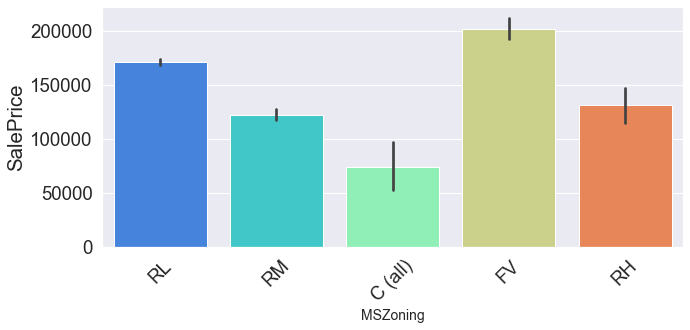

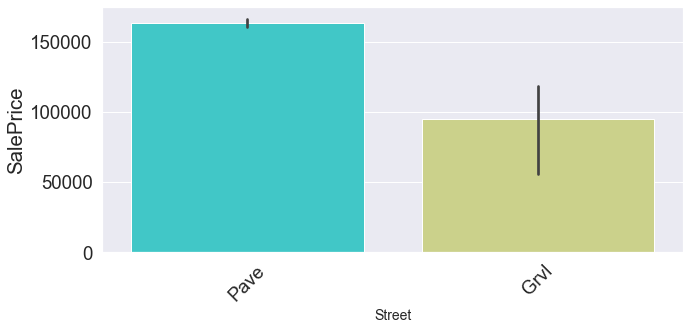

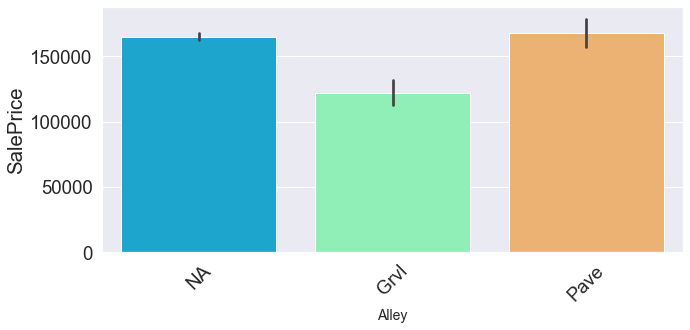

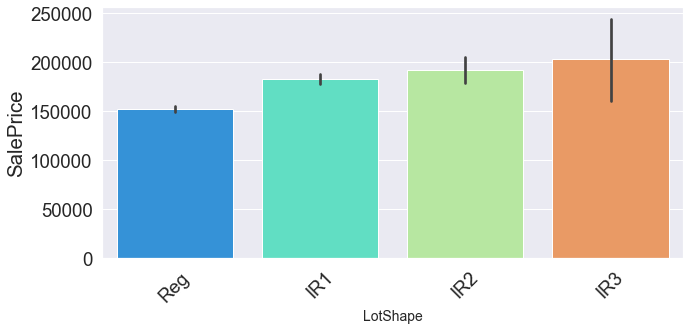

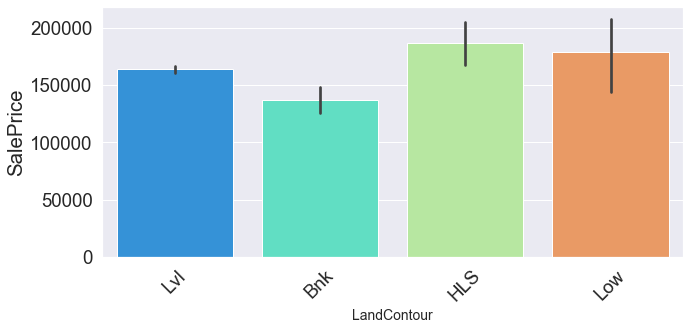

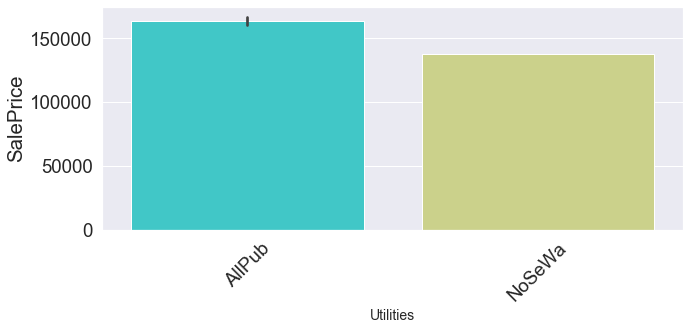

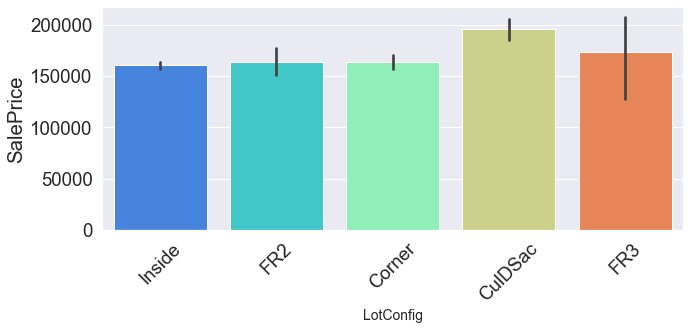

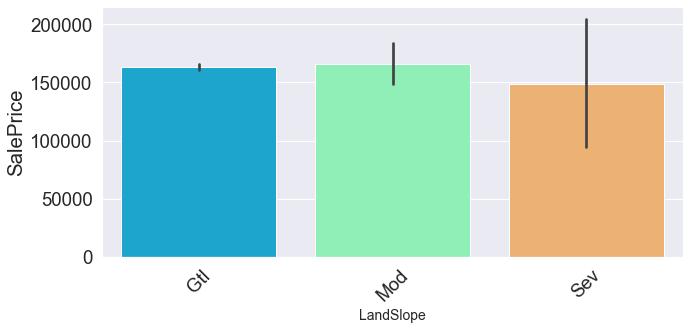

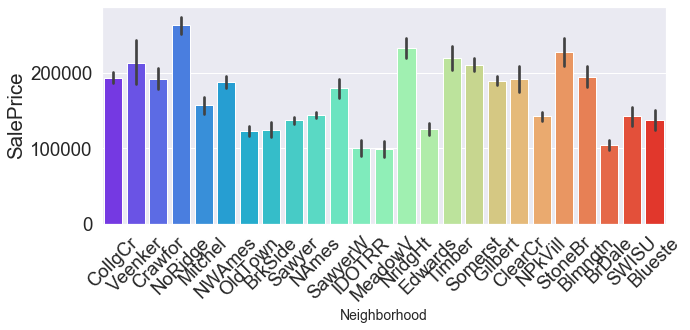

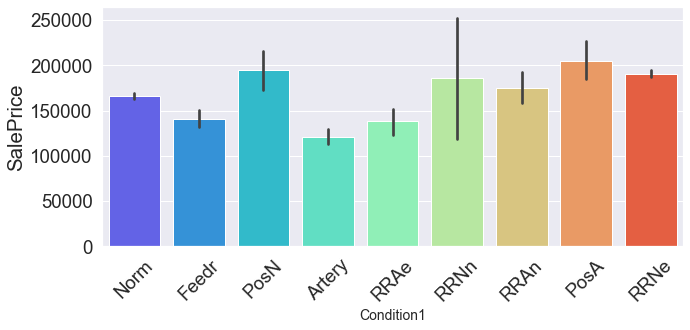

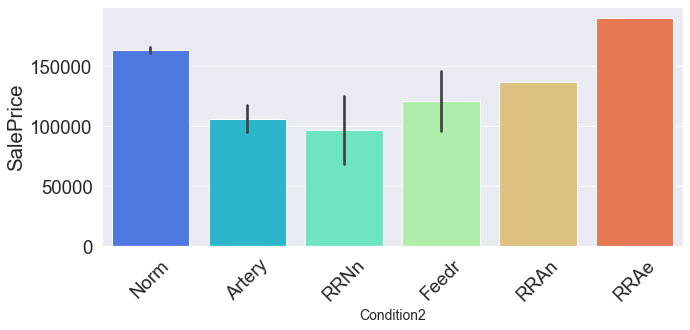

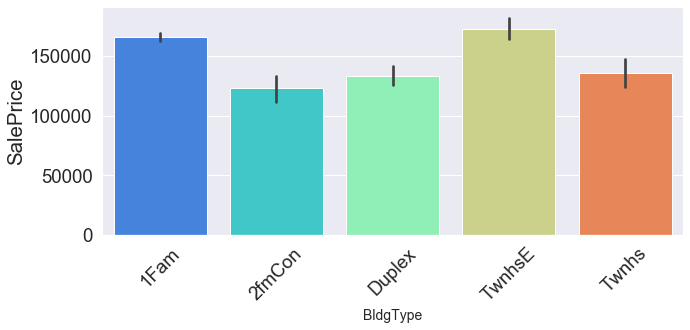

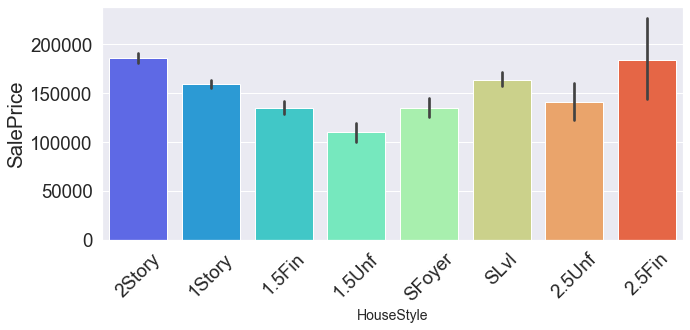

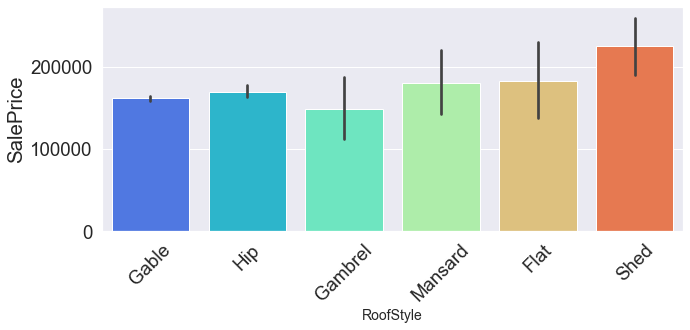

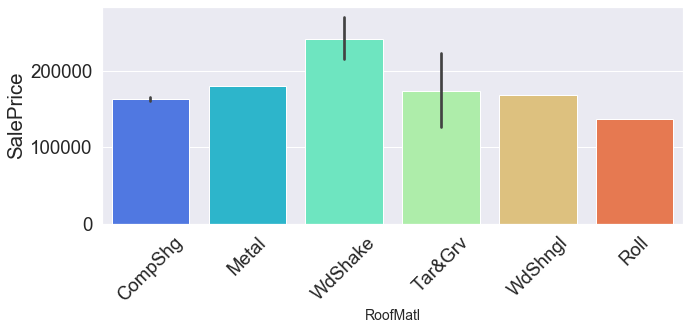

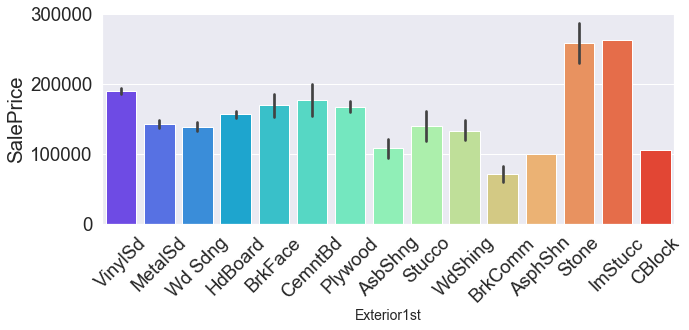

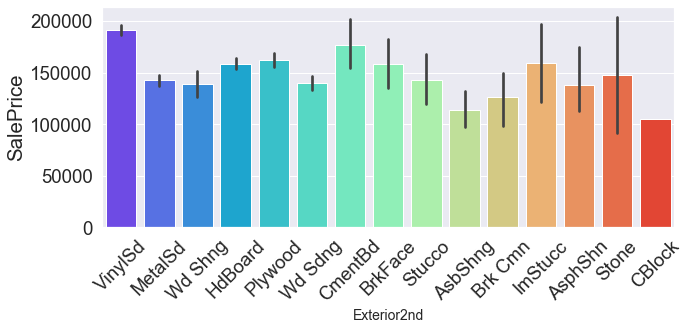

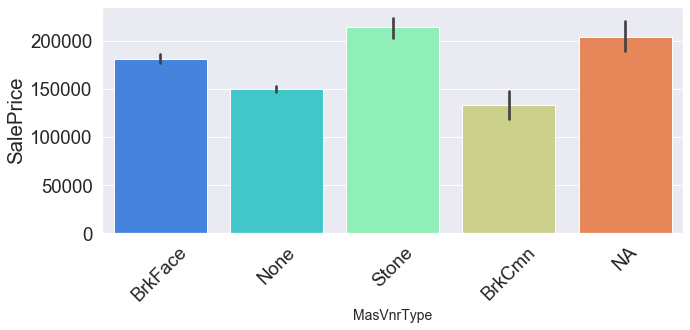

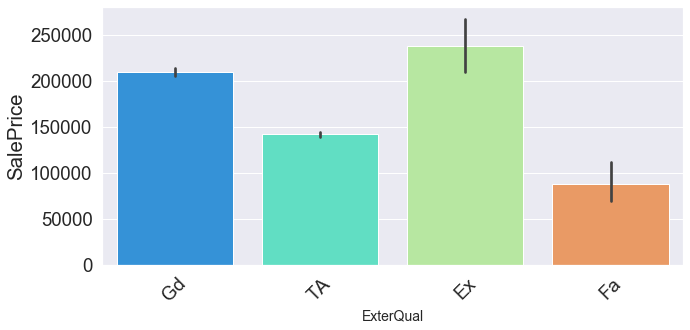

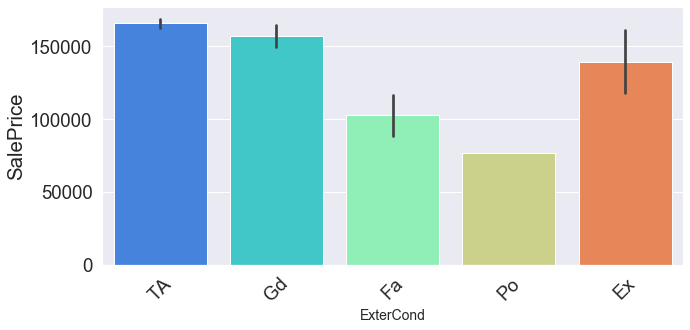

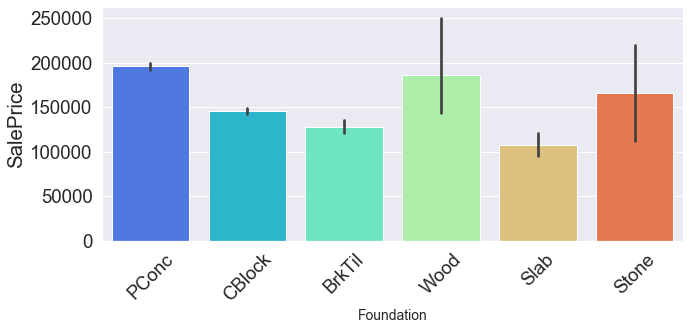

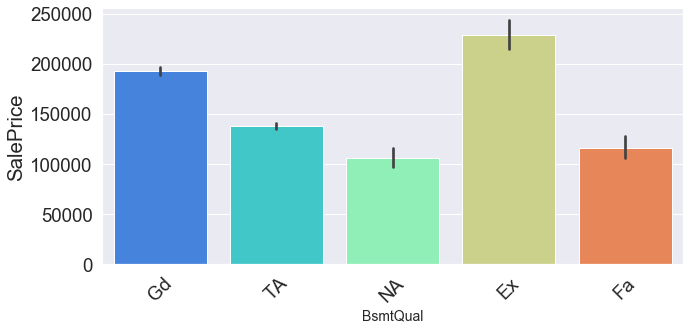

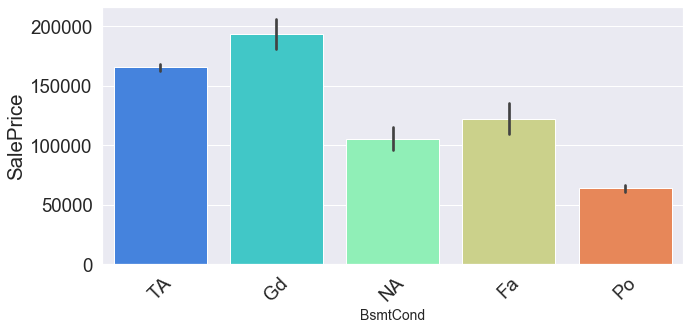

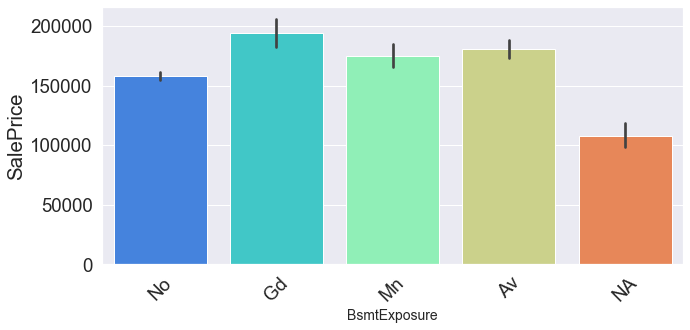

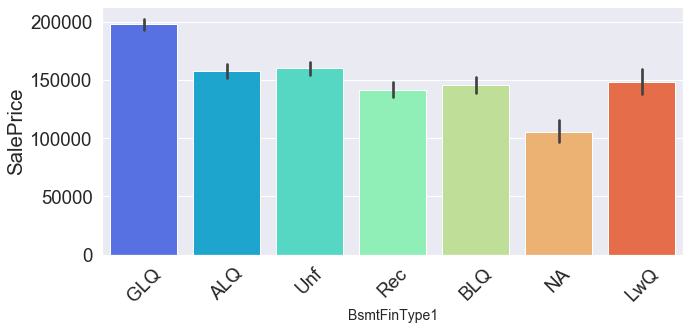

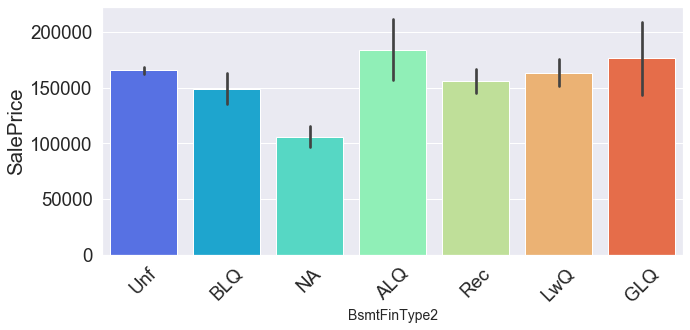

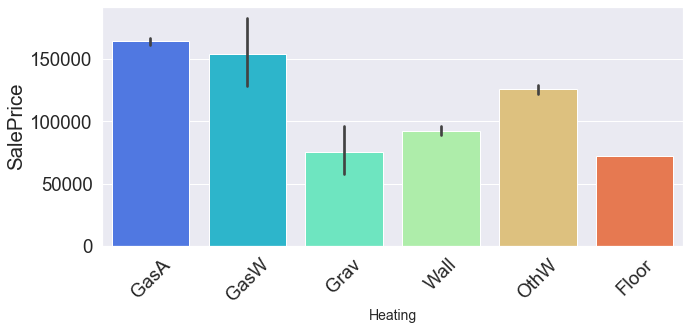

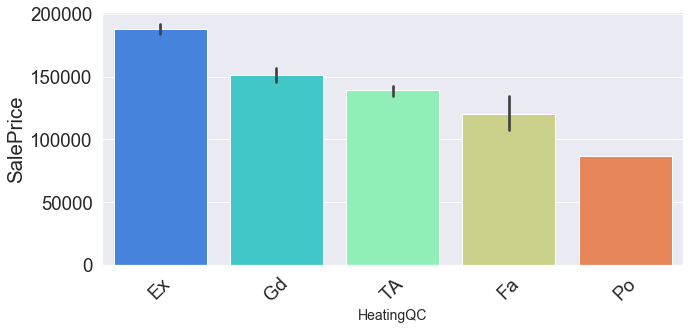

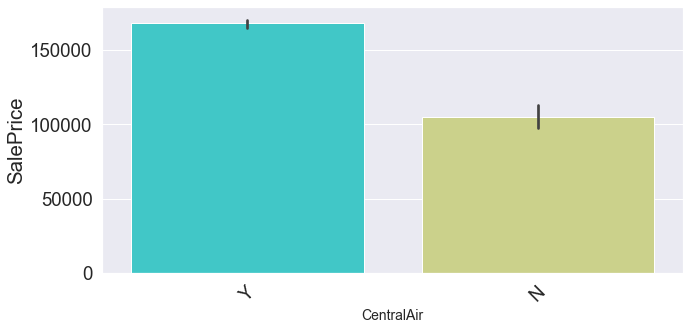

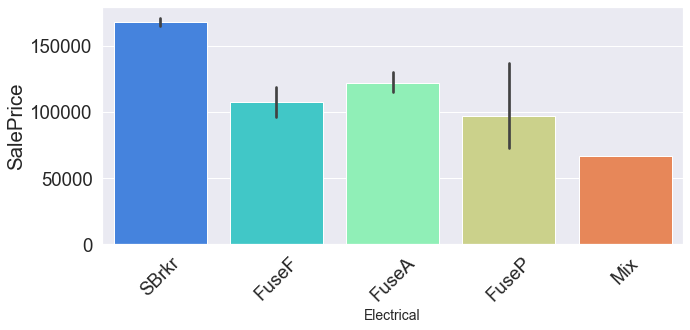

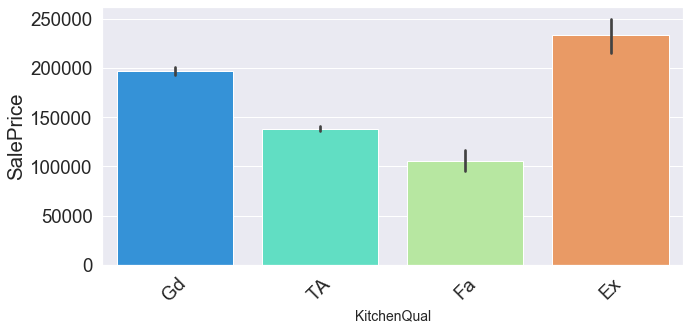

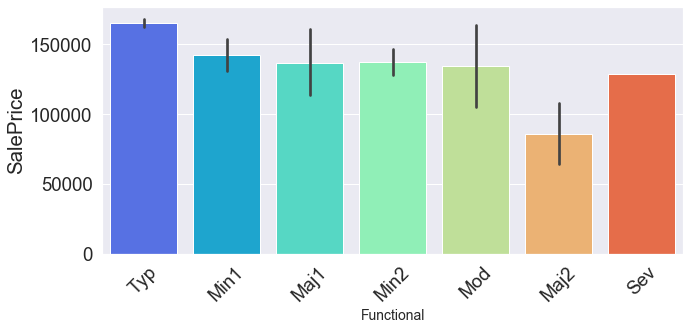

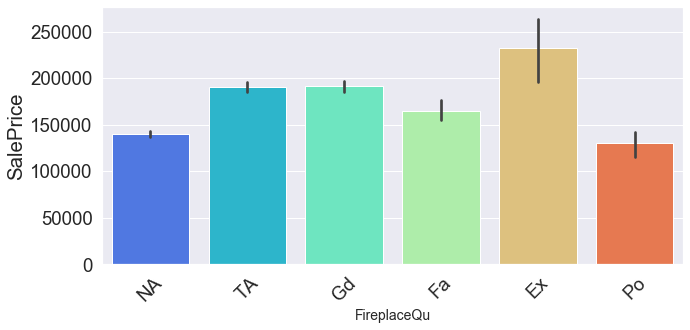

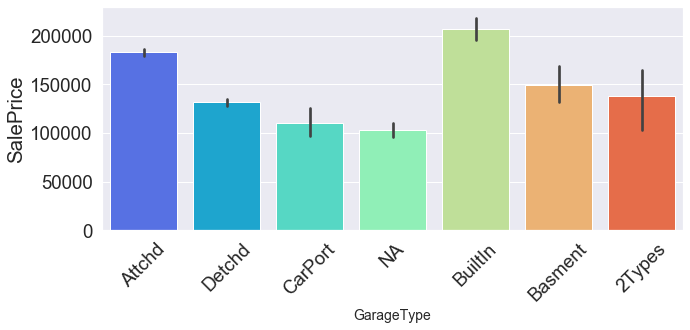

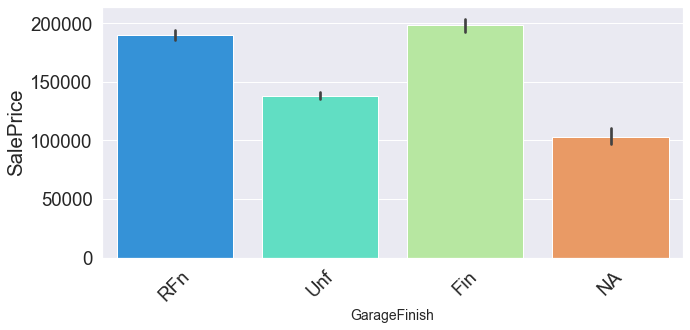

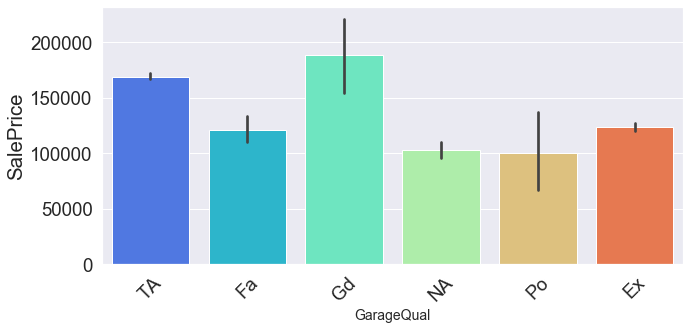

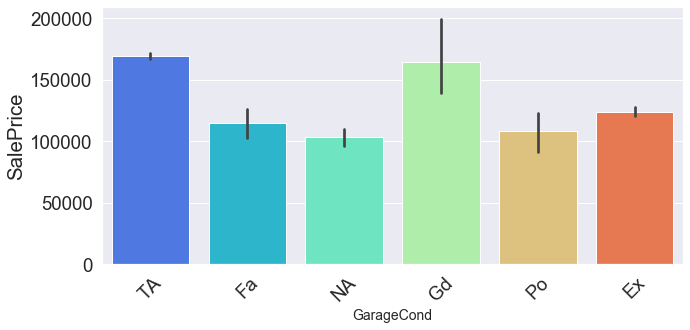

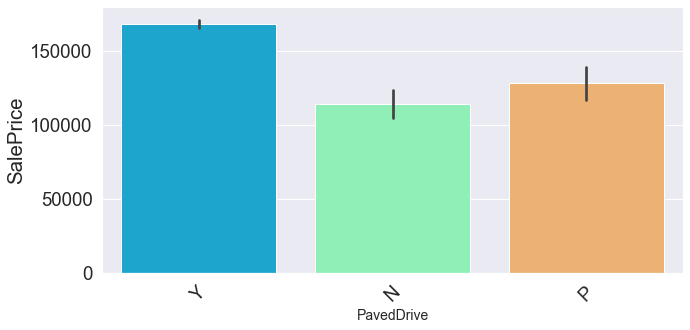

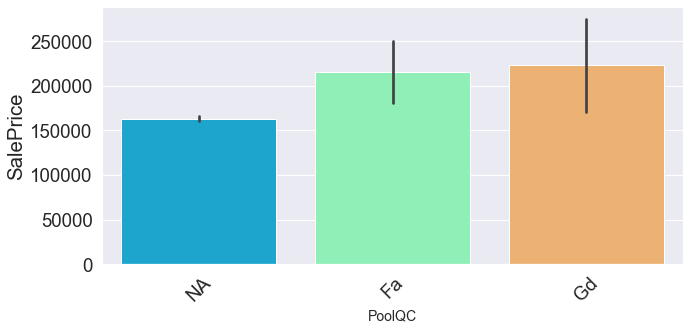

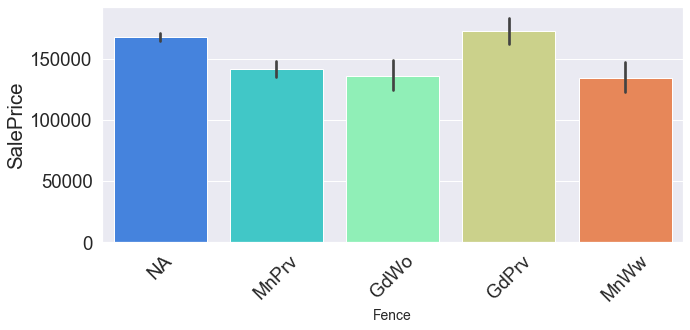

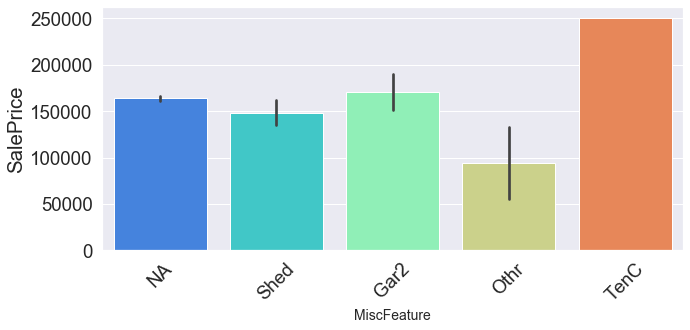

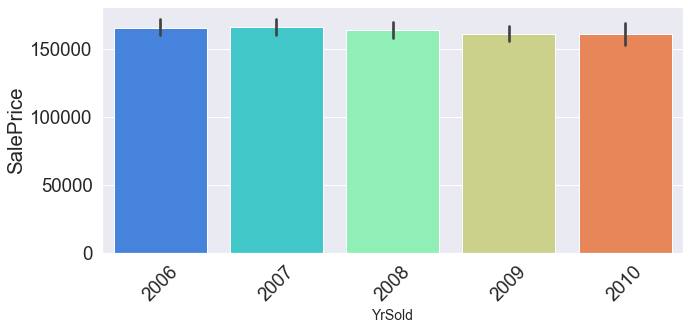

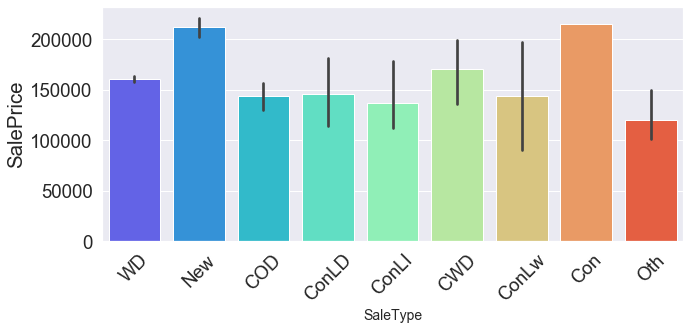

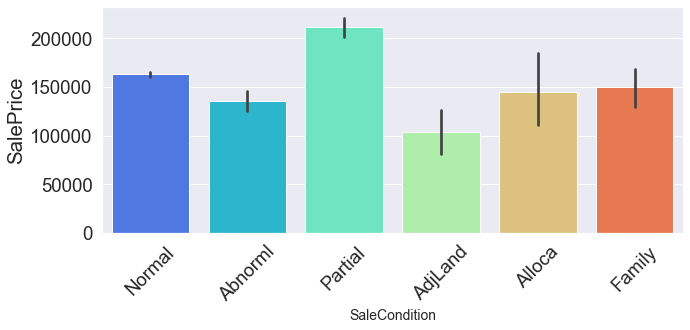

In [21]:
# selecionar as colunas do tipo object

var = df.select_dtypes([np.object]).columns
categorical_variables=[]
for x in var:
    if 1<len(df[x].value_counts())<30 and x!='SalePrice':
        categorical_variables.append(x)
    

def bar_plot(data, x, y):
    data[x] = data[x].fillna("NaN")
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
    sns.barplot(x = x, y = y, data = data, palette="rainbow")
    ax.set_xlabel(x, fontsize = 14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    plt.tight_layout()
    plt.show()

# plotar as variáveis categóricas em função da variável default.

for x in categorical_variables:
    bar_plot(data = df, x = x, y = 'SalePrice')

### Feature engineering

Vamos criar colunas que contenham o valor total da metragem da casa, tamanho da varanda e total de banheiros.

In [22]:
df["Total_SF"]=df['TotalBsmtSF']+df['1stFlrSF']+df['2ndFlrSF']

In [23]:
df['porch_total']=df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['ScreenPorch']

In [24]:
df['total_bath']=df['FullBath']+df['HalfBath']

Também vamos criar colunas que indiquem se a casa tem ou não piscina, segundo andar, garagem, porão e lareira.

In [25]:
df['has_pool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0).astype(object)
df['has_2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)
df['has_garage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0).astype(object)
df['has_bsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)
df['has_fireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0).astype(object)

In [26]:
df=df.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
            'FullBath','HalfBath'],1)

### Uniformizar as variáveis numéricas

In [27]:
# Selecionar novamente as informações numéricas

num_var=df.drop('SalePrice',1).select_dtypes([np.int64,np.float64]).columns
data_num=df[num_var]
data_num_scaled=pd.DataFrame(columns=num_var)

In [28]:
scaler=StandardScaler()
scaler.fit(data_num)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
scaled_inputs=scaler.transform(data_num)
scaled_data=pd.DataFrame(scaled_inputs)

In [30]:
data_num_scaled=scaled_data

In [31]:
df.reset_index(drop=True, inplace=True)
data_num_scaled.reset_index(drop=True, inplace=True)

In [32]:
df[num_var]=data_num_scaled

### Encoding das variáveis categóricas

Enconding em todas as variáveis categóricas

In [33]:
for n in df.select_dtypes([np.object]).columns:
    u=n
    u= preprocessing.LabelEncoder()
    df[n] = u.fit_transform(df[n])

In [34]:
num_features = df.dtypes[df.dtypes != 'object'].index
skewed_features = df[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(15)

,Skew
Utilities,36.235352
MiscVal,23.307826
PoolArea,18.527943
has_pool,18.055555
RoofMatl,10.104591
Heating,9.419075
LowQualFinSF,8.986910
Condition2,6.622395
LandSlope,5.366290
MiscFeature,4.888629


In [35]:
df=df.drop(['Utilities','MiscVal','PoolArea','has_pool','RoofMatl','LowQualFinSF','Condition2',
           'LandSlope','MiscFeature','Heating','Id','KitchenAbvGr'],1)

In [36]:
y=df['SalePrice']
X=df.drop('SalePrice',1)
#Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Modelagem

Vamos testar vários modelos para identificar qual irá obter melhor performance. A métrica utilizada será mean_squared_log_error.

In [37]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

#### Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features='sqrt',n_estimators=1000,max_depth=10,oob_score=True,bootstrap=True) 
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
print(rf.score(X_test, y_test))
print(rf.score(X_train, y_train))
print(mean_squared_log_error(y_test,rf_pred))

0.8661452709878886
0.9677355470123712
0.0121834171301208


#### Gradient Boosting Regressor

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_features='log2',n_estimators=1000,max_depth=5)
gbr.fit(X_train, y_train)
gbr_pred=gbr.predict(X_test)
print(gbr.score(X_test, y_test))
print(gbr.score(X_train, y_train))
print(mean_squared_log_error(y_test,gbr_pred))

0.8806361387239217
0.9999864791644621
0.010438831593134443


#### Xgboost

In [40]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xb = xgb.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=900,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=101,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)
xb.fit(X_train, y_train) 
xb_predictions = xb.predict(X_test)
print(xb.score(X_test, y_test))
print(xb.score(X_train, y_train))
print(mean_squared_log_error(y_test,xb_predictions))

0.9018100495033328
0.9790877766721464
0.008732711104936399


#### LGBMRegressor

In [41]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11)
lightgbm.fit(X_train, y_train) 
lightgbm_predictions = lightgbm.predict(X_test)
print(lightgbm.score(X_test, y_test))
print(lightgbm.score(X_train, y_train))
print(mean_squared_log_error(y_test,lightgbm_predictions))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


0.8974932151120264
0.965491581527604
0.009016720395921525


#### Lasso

In [42]:
a_lasso = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7,alphas = a_lasso, random_state = 42, cv=kfolds))
lasso.fit(X_train, y_train)
#lasso_score = cross_val_score(lasso, X, y, cv=kfolds, scoring='neg_mean_squared_error')
lasso_predictions=lasso.predict(X_test)
print(lasso.score(X_test, y_test))
print(lasso.score(X_train, y_train))
print(mean_squared_log_error(y_test,lasso_predictions))

0.8787986200977077
0.8977787321711732
0.011596257121567451


#### Ridge

In [43]:
a_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = a_ridge, cv=kfolds))
ridge.fit(X_train, y_train)
#ridge_score = cross_val_score(ridge, X, y, cv=kfolds, scoring='neg_mean_squared_error')
ridge_predictions=ridge.predict(X_test)
print(ridge.score(X_test, y_test))
print(ridge.score(X_train, y_train))
print(mean_squared_log_error(y_test,ridge_predictions))

0.8783149562000738
0.8967228061811688
0.011427291012565427


#### Elasticnet

In [44]:
a_elastic = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=a_elastic, cv=kfolds, l1_ratio=e_l1ratio))
elasticnet.fit(X_train, y_train)
#elasticnet_score = cross_val_score(lasso, X, y, cv=kfolds, scoring='neg_mean_squared_error')
elasticnet_predictions=elasticnet.predict(X_test)
print(elasticnet.score(X_test, y_test))
print(elasticnet.score(X_train, y_train))
print(mean_squared_log_error(y_test,elasticnet_predictions))

0.8790884899380399
0.8977307651184856
0.011556272351725804


#### StackingRegressor

In [45]:
from sklearn.ensemble import StackingRegressor

estimators = [
    (gbr,xb)]
sr = StackingRegressor(
    estimators=estimators,
    final_estimator=lightgbm
)

sr.fit(X_train, y_train.values.ravel())
sr_predictions = sr.predict(X_test)
print(sr.score(X_test, y_test))
print(sr.score(X_train, y_train))
print(mean_squared_log_error(y_test,sr_predictions))

0.8985424735520009
0.9703490361024697
0.009348249986026208


#### StackingCVRegressor

In [46]:
from mlxtend.regressor import StackingCVRegressor

scvr = StackingCVRegressor(regressors=(rf,xb,lightgbm,lasso,ridge,elasticnet,gbr),
                                meta_regressor=xb,
                                use_features_in_secondary=True)
scvr.fit(np.array(X_train), np.array(y_train.values.ravel()))
scvr_pred = scvr.predict(np.array(X_test))
print(scvr.score(np.array(X_test), np.array(y_test.values.ravel())))
print(scvr.score(np.array(X_train), np.array(y_train.values.ravel())))
print(mean_squared_log_error(y_test,scvr_pred))

0.9008481468365831
0.9823598622730357
0.008888318332091132


### Comparação entre os modelos

In [47]:
pred_train=pd.DataFrame()
avg=(rf_pred+gbr_pred+xb_predictions+lightgbm_predictions+sr_predictions+scvr_pred+lasso_predictions+ridge_predictions+elasticnet_predictions)/9

models=['rf','grb','xb','lightgbm','sr','scvr','lasso','ridge','elasticnet','avg']
values=[mean_squared_log_error(y_test,rf_pred),mean_squared_log_error(y_test,gbr_pred),
        mean_squared_log_error(y_test,xb_predictions),mean_squared_log_error(y_test,lightgbm_predictions),
        mean_squared_log_error(y_test,sr_predictions),mean_squared_log_error(y_test,scvr_pred),
        mean_squared_log_error(y_test,lasso_predictions),mean_squared_log_error(y_test,ridge_predictions),
        mean_squared_log_error(y_test,elasticnet_predictions),mean_squared_log_error(y_test,avg)]
pred_train['model']=models
pred_train['mean_squared_log_error']=values
pred_train.sort_values(by='mean_squared_log_error')

,model,mean_squared_log_error
9,avg,0.008179
2,xb,0.008733
5,scvr,0.008888
3,lightgbm,0.009017
4,sr,0.009348
1,grb,0.010439
7,ridge,0.011427
8,elasticnet,0.011556
6,lasso,0.011596
0,rf,0.012183


### Importância das variáveis

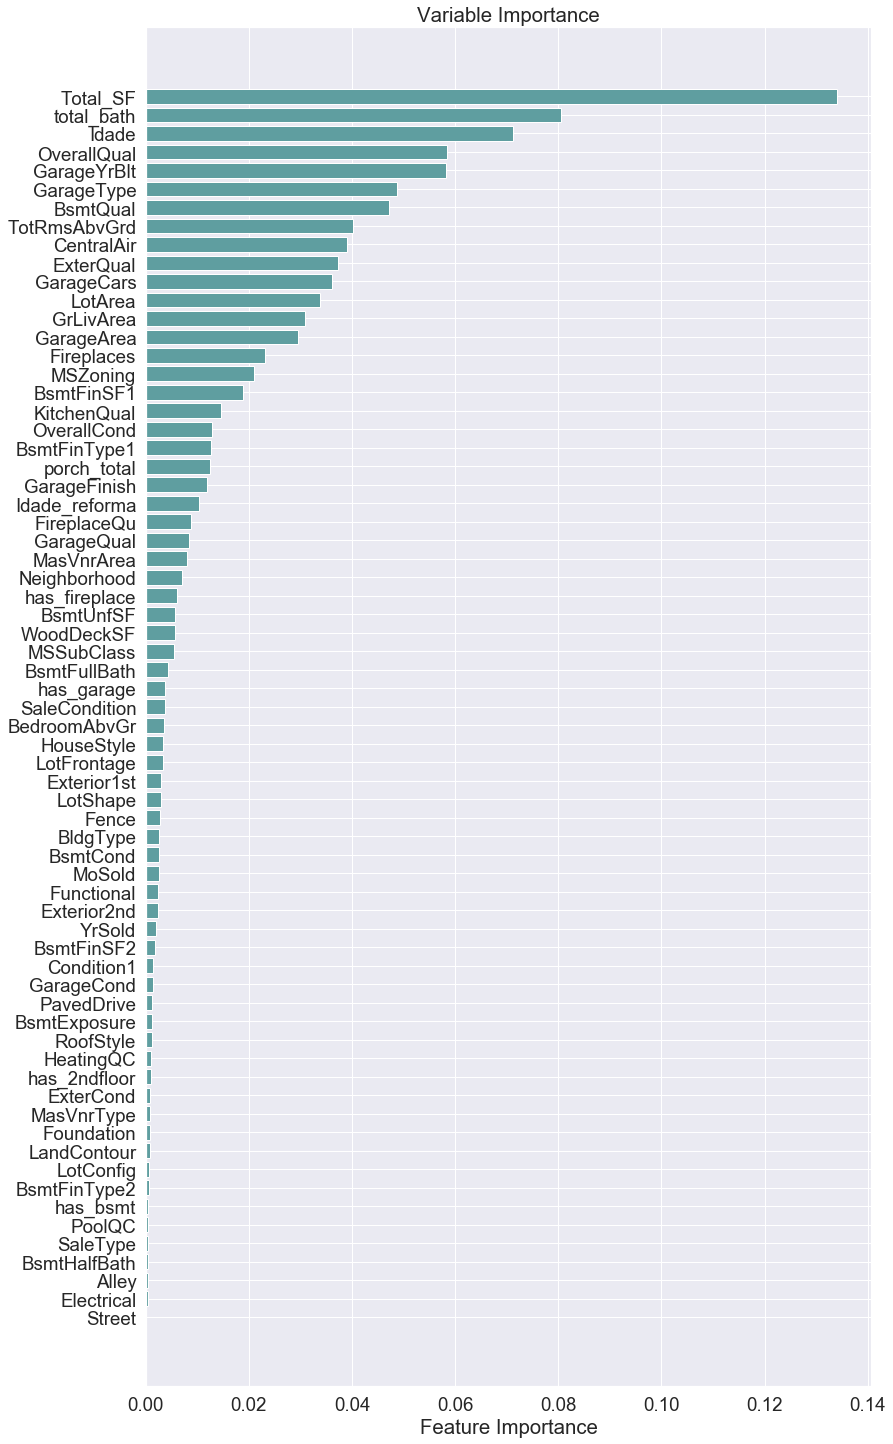

In [48]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(13, 25))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='CadetBlue')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Variable Importance')
plt.show()

### Importar arquivo de teste

In [49]:
teste=pd.read_csv('test.csv')
data_teste=teste.copy()

Faremos todo o tratamento que foi realizado no dataset train.

In [50]:
# Separação das variáveis numéricas e categéoricas

num_var=data_teste.select_dtypes([np.int64,np.float64]).columns
cat_var=data_teste.select_dtypes([np.object]).columns


# De acordo com o data_description, existem 3 valores de alley : Grvl, Pave e NA
# Os valores nulos serão substituídos por NA
data_teste['Electrical']=data_teste['Electrical'].fillna('SBrkr')
data_teste['KitchenQual']=data_teste['KitchenQual'].fillna('TA')
data_teste['Functional']=data_teste['Functional'].fillna('Typ')
data_teste['SaleType']=data_teste['SaleType'].fillna('Oth')
data_teste['Exterior1st'] = data_teste['Exterior1st'].fillna(data_teste['Exterior1st'].mode()[0])
data_teste['Exterior2nd'] = data_teste['Exterior2nd'].fillna(data_teste['Exterior2nd'].mode()[0])
data_teste['SaleType'] = data_teste['SaleType'].fillna(data_teste['SaleType'].mode()[0])

for n in cat_var:
    if n in other or n in basement or n in garage or n in pool or n in alley or n in fireplace or n in sf or n in mas or n in kitchen or n in bath or n in exterior or n in porch:
        if data_teste[n].isnull().sum()!=0:
            data_teste[n]=data_teste[n].fillna('NA')

for n in num_var:
    if n in other or n in basement or n in garage or n in pool or n in alley or n in fireplace or n in sf or n in mas or n in kitchen or n in bath or n in exterior or n in porch:
         if data_teste[n].isnull().sum()!=0:
            data_teste[n] = data_teste[n].replace(np.nan, 0)
            
data_teste['Idade']=data_teste['YrSold']-data_teste['YearBuilt']
data_teste['Idade_reforma']=data_teste['YrSold']+data_teste['YearRemodAdd']
data_teste['YrSold']=data_teste['YrSold'].astype(object)
data_teste=data_teste.drop(['YearRemodAdd','YearBuilt'],1)            
            
data_teste["Total_SF"]=data_teste['TotalBsmtSF']+data_teste['1stFlrSF']+data_teste['2ndFlrSF']

data_teste['porch_total']=data_teste['OpenPorchSF']+data_teste['EnclosedPorch']+data_teste['3SsnPorch']+data_teste['ScreenPorch']

data_teste['total_bath']=data_teste['FullBath']+data_teste['HalfBath']

data_teste['has_pool'] = data_teste['PoolArea'].apply(lambda x: 1 if x > 0 else 0).astype(object)
data_teste['has_2ndfloor'] = data_teste['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)
data_teste['has_garage'] = data_teste['GarageArea'].apply(lambda x: 1 if x > 0 else 0).astype(object)
data_teste['has_bsmt'] = data_teste['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0).astype(object)
data_teste['has_fireplace'] = data_teste['Fireplaces'].apply(lambda x: 1 if x > 0 else 0).astype(object)

data_teste=data_teste.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
            'FullBath','HalfBath'],1)
### Uniformizar as variáveis numéricas

num_var=data_teste.select_dtypes([np.int64,np.float64]).columns
data_num=data_teste[num_var]
data_num_scaled=pd.DataFrame(columns=num_var)

scaler=StandardScaler()
scaler.fit(data_num)

scaled_inputs=scaler.transform(data_num)
scaled_data=pd.DataFrame(scaled_inputs)

data_num_scaled=scaled_data

data_teste.reset_index(drop=True, inplace=True)
data_num_scaled.reset_index(drop=True, inplace=True)

data_teste[num_var]=data_num_scaled

### Encoding das variáveis categóricas

for n in data_teste.select_dtypes([np.object]).columns:
    u=n
    u= preprocessing.LabelEncoder()
    data_teste[n] = u.fit_transform(data_teste[n])    
    
    
data_teste=data_teste.drop(['Utilities','MiscVal','PoolArea','has_pool','RoofMatl','LowQualFinSF','Condition2',
           'LandSlope','MiscFeature','Heating','Id','KitchenAbvGr'],1)

### Previsão utilizando o modelo

In [51]:
avg_test=(rf.predict(data_teste)+gbr.predict(data_teste)+xb.predict(data_teste)+lightgbm.predict(data_teste)+sr.predict(data_teste)+scvr.predict(np.array(data_teste)))/6

predict=pd.DataFrame()
predict['Id']=teste['Id']
predict['SalePrice']=avg_test
predict

,Id,SalePrice
0,1461,121835.599972
1,1462,149526.327464
2,1463,170213.348413
3,1464,177324.198049
4,1465,159229.117739
...,...,...
1454,2915,93110.769701
1455,2916,87815.691384
1456,2917,154285.778252
1457,2918,113005.749224
